# MedCLIP Captioning Model

In [1]:
import os
import collections
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

import requests
from os.path import join, expanduser

In [2]:
SEED = 111
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Dataset files
DATASET_ROOT_DIR = 'datasets'
IMAGES_DIR = 'cases_images'
DATASET_ANNOTATIONS = 'Dataset_MedPix_V1.xlsx'

IMAGES_PATH = os.path.join(DATASET_ROOT_DIR, IMAGES_DIR)
ANNOTATION_FILE = os.path.join(DATASET_ROOT_DIR, DATASET_ANNOTATIONS)

# Model Weights
MODELS_ROOT_DIR = 'models'
MODEL_DIR = 'captioning_model'
WEIGHTS_FILE = 'weights'

MODEL_DIR_PATH = os.path.join(MODELS_ROOT_DIR, MODEL_DIR)
WEIGHTS_FILE_PATH = os.path.join(MODEL_DIR_PATH, WEIGHTS_FILE)

In [4]:
# Number of captions per image
CAPTIONS_PER_IMAGE = 1

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 100

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

## Load dataset

In [5]:
annotations = pd.read_excel(ANNOTATION_FILE)

In [6]:
# Download image files
if not os.path.exists(IMAGES_PATH):
    for index, row in annotations.iterrows():
        url = row['Image_URL']
        file_name = str(index) + '.jpg'
        r = requests.get(url)
        filepath = join(root_dir, images_dir)

    if not os.path.exists(filepath):
        os.makedirs(filepath)

    filepath = join(filepath, file_name)

    if r.status_code == 200:
        with open(filepath, 'wb') as f:
            f.write(r.content)

print('Image files are downloaded in: ' + IMAGES_PATH)

Image files are downloaded in: datasets/cases_images


In [7]:
def load_captions_data():
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    
    image_path_to_caption = collections.defaultdict(list)
    
    text_data = []

    for index, row in annotations.iterrows():
        caption = ('<start> ' + 'Modality: ' + str(row['Core_Modality']) + ', ' +
                   'Plane: ' + str(row['Plane']) + ', ' +
                   'Category: ' + str(row['Category']) + ', ' +
                   'Diagnosis: ' + str(row['Caption']) + ' <end>')
        
        image_path = IMAGES_PATH + "/" + str(row['ID']) + ".jpg"
        image_path_to_caption[image_path].append(caption)
        
        text_data.append(caption)

    return image_path_to_caption, text_data

In [8]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

In [9]:
# Load the dataset
captions_mapping, text_data = load_captions_data()

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  29280
Number of validation samples:  7321


In [10]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [11]:
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# To keep caption the structure
strip_chars = strip_chars.replace(":", "")
strip_chars = strip_chars.replace(",", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

In [12]:
def decode_and_resize(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def read_train_image(img_path, size=IMAGE_SIZE):
    img = decode_and_resize(img_path)
    img = image_augmentation(tf.expand_dims(img, 0))[0]
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def read_valid_image(img_path, size=IMAGE_SIZE):
    img = decode_and_resize(img_path)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions, split="train"):
    if split == "train":
        img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
            read_train_image, num_parallel_calls=AUTOTUNE
        )
    else:
        img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
            read_valid_image, num_parallel_calls=AUTOTUNE
        )

    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )

    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset

In [13]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(
    list(train_data.keys()), list(train_data.values()), split="train"
)

valid_dataset = make_dataset(
    list(valid_data.keys()), list(valid_data.values()), split="valid"
)

## Define the models

In [14]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB3(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

In [15]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=CAPTIONS_PER_IMAGE,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [16]:
# Initialize the model
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder 
)

## Train the model

In [17]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [18]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )

In [19]:
# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/10
458/458 [==============================] - 4466s 10s/step - loss: 6.2808 - acc: 0.1013 - val_loss: 4.4190 - val_acc: 0.3334
Epoch 2/10
458/458 [==============================] - 4453s 10s/step - loss: 4.0808 - acc: 0.3473 - val_loss: 3.7274 - val_acc: 0.3902
Epoch 3/10
458/458 [==============================] - 4364s 9s/step - loss: 3.5921 - acc: 0.3921 - val_loss: 3.3966 - val_acc: 0.4158
Epoch 4/10
458/458 [==============================] - 4287s 9s/step - loss: 3.2926 - acc: 0.4187 - val_loss: 3.1546 - val_acc: 0.4371
Epoch 5/10
458/458 [==============================] - 4360s 9s/step - loss: 3.0651 - acc: 0.4380 - val_loss: 2.9707 - val_acc: 0.4538
Epoch 6/10
458/458 [==============================] - 4283s 9s/step - loss: 2.8743 - acc: 0.4531 - val_loss: 2.8106 - val_acc: 0.4726
Epoch 7/10
458/458 [==============================] - 4285s 9s/step - loss: 2.7075 - acc: 0.4738 - val_loss: 2.6769 - val_acc: 0.4892
Epoch 8/10
458/458 [==============================] - 4363s 

In [20]:
# Save the model weights
caption_model.save_weights(WEIGHTS_FILE_PATH, save_format='tf')

print('Weights are saved.')

Weights are saved.


In [21]:
# Initialize the model
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder 
)

# Load the model weights
print('Loading captioning model...')

caption_model.load_weights(WEIGHTS_FILE_PATH)

print('Model is loaded from: ' + WEIGHTS_FILE_PATH)

Loading captioning model...
Model is loaded from: models/captioning_model/weights


## Test the model

In [22]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_valid_image(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print(decoded_caption)

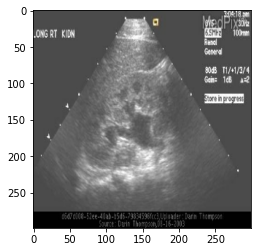

modality us plane transverse category neoplasm carcinoma diagnosis ultrasound image of the right kidney demonstrates a large mass with heterogeneous echotexture heterogeneous echotexture heterogeneous echotexture heterogeneous enhancement heterogeneous and cystic components heterogeneous and solid components heterogeneous and cystic components hyperechoic foci within the mass echogenic foci of the echogenic foci of the echogenic foci within the echogenic foci of the echogenic foci of the echogenic


In [23]:
generate_caption()

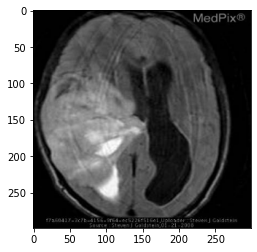

modality mr plane axial category neoplasm glial diagnosis large left frontal lobe mass with cystic components peri lesional edema in cerebellum mass effect on right no restricted diffusion no restricted diffusion


In [24]:
generate_caption()

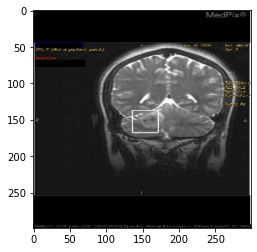

modality mr plane coronal category neoplasm glial diagnosis coronal t2 coronal and coronal flair images demonstrate a large cystic lesion within the right parietal lobe with a thin rim of the lesion is hyperintense lesion is hyperintense on t1 and hypointense rim of the lesion edema edema edema edema


In [25]:
generate_caption()